
## Step 1: Imports and Data Loading
# In this step, we import the necessary libraries and load the dataset.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the window size
window_size = 5

# Load dataset
data = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date')

# Convert 'Page.Loads' from string to integer
data['Page.Loads'] = data['Page.Loads'].str.replace(',', '').astype(int)

# Drop unnecessary columns
columns_to_drop = ["Row", "Day", "Day.Of.Week", "Unique.Visits", "Returning.Visits", "First.Time.Visits"]
data.drop(columns=columns_to_drop, inplace=True)


## Step 2: Data Normalization and Sequence Creation
# Here, we normalize the data and define functions to create sequences for the LSTM model.


In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Function to create sequences
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        sequence = data[i:(i + window_size)]
        label = data[i + window_size]
        X.append(sequence)
        y.append(label)
    return np.array(X), np.array(y)

# Function to prepare data
def prepare_data(data, start_date, end_date, window_size, scaler):
    data_filtered = data.loc[start_date:end_date, 'Page.Loads'].values.reshape(-1, 1)
    data_normalized = scaler.transform(data_filtered)
    X, y = create_sequences(data_normalized, window_size)
    X = X.reshape((X.shape[0], window_size, 1))
    return X, y

## Step 3: Model Definition
# We define the LSTM model architecture.

In [15]:
# Function to create the model
def create_model(window_size):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


## Step 4: Prediction and Plotting
# This part contains the function to plot the predictions and actual values, providing a visual comparison.


In [16]:
def plot_predictions(test, y_test, predicted_test, start_date, end_date, window_size, date_time):
    test_dates = test[start_date:end_date].index  # Adjusting the test_dates to match y_test and predicted_test
    uncertainty = 0.10 * predicted_test.flatten()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(test_dates, y_test, color='red', label='Actual')
    ax.plot(test_dates, predicted_test, color='blue', label='Predicted')
    ax.fill_between(test_dates, 
                    (predicted_test.flatten() - uncertainty), 
                    (predicted_test.flatten() + uncertainty), 
                    color='blue', alpha=0.2)
    ax.set_title( 'LSTM Page Load Time Prediction with ' + date_time + ' of training data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Page Loads')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_xlim([pd.Timestamp(start_date) - pd.DateOffset(days=5), pd.Timestamp(end_date) + pd.DateOffset(days=5)])
    ax.set_ylim([0, max(max(y_test), max(predicted_test)) + 1000])
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

## Step 5: Training and Evaluation Loop
# In this final step, we train the model using different training periods and evaluate its performance.


In [17]:
# Prepare training data for 2019
start_date = '2019-01-01'
end_date = '2019-12-26'

# Define testing period
testing_start_date = '2019-12-27'
testing_end_date = '2020-03-31'

scaler.fit(data.loc[start_date:end_date, ['Page.Loads']])
X_train, y_train = prepare_data(data, start_date, end_date, window_size, scaler)


c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Train the model for 2019 data

In [18]:
%%time
model = create_model(window_size)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3340  
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2286 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1461 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0841 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0510 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0509 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0465 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0463 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0426 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0462
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0431
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0416
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0433 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0430
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0394 
Epoch 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


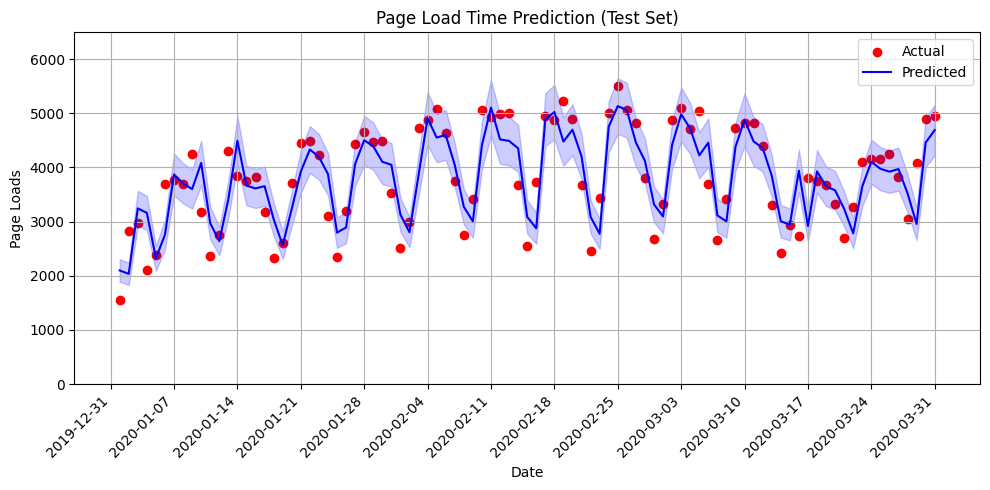

In [19]:
# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc['2020-01-01':'2020-03-31', 'Page.Loads']
date_time = '1 year'
# Ensure 1-dimensional arrays for metric calculation
y_test_actual = y_test_actual.to_numpy().flatten()
predicted_test = predicted_test.flatten()[:len(y_test_actual)]  # Ensure the prediction length matches the actual data length

# Calculate metrics
mse = mean_squared_error(y_test_actual, predicted_test)
rmse = np.sqrt(mse)  # Calculate RMSE
mae = mean_absolute_error(y_test_actual, predicted_test)
mape = np.mean(np.abs((y_test_actual - predicted_test) / y_test_actual)) * 100

# Store results
results_2019 = (start_date, end_date, rmse, mae, mape)

# Plot predictions
plot_predictions(data, y_test_actual, predicted_test, '2020-01-01', '2020-03-31', window_size, date_time)

## Step 6: Training and Evaluation for 2018 Data
# We train the model using data from 2018 and measure the training time.


In [20]:
# Prepare training data for 2018
start_date = '2018-01-01'
end_date = '2019-12-26'
scaler.fit(data.loc[start_date:end_date, ['Page.Loads']])
X_train, y_train = prepare_data(data, start_date, end_date, window_size, scaler)

c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [21]:
%%time
# Train the model for 2018 data
model = create_model(window_size)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1814   
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0531 
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0416 
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0392 
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0359 
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367 
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0338 
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0326 
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0323 
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0318 
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0264 
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0257 
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239 
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0220 
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 
Epoch 16/50
2

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


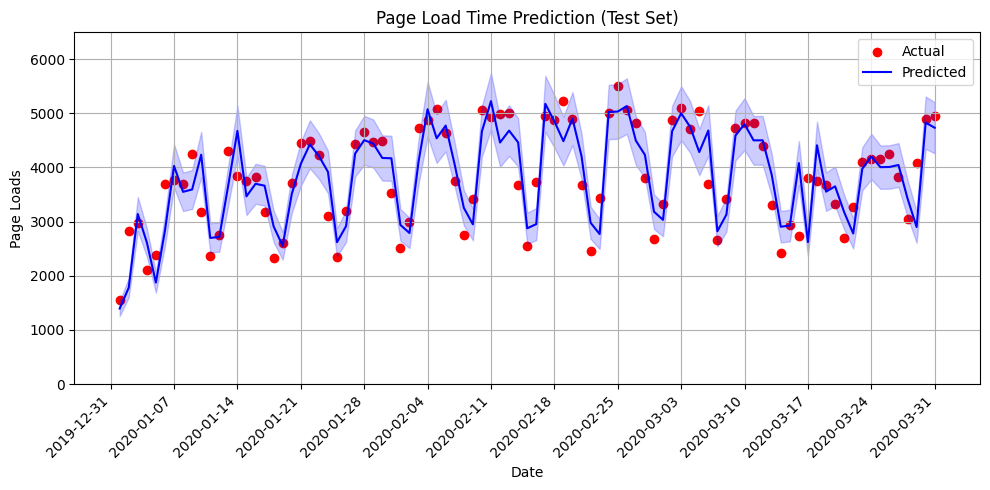

In [22]:
# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc['2020-01-01':'2020-03-31', 'Page.Loads']
date_time = '2 years'
# Ensure 1-dimensional arrays for metric calculation
y_test_actual = y_test_actual.to_numpy().flatten()
predicted_test = predicted_test.flatten()[:len(y_test_actual)]  # Ensure the prediction length matches the actual data length

# Calculate metrics
mse = mean_squared_error(y_test_actual, predicted_test)
rmse = np.sqrt(mse)  # Calculate RMSE
mae = mean_absolute_error(y_test_actual, predicted_test)
mape = np.mean(np.abs((y_test_actual - predicted_test) / y_test_actual)) * 100

# Store results
results_2018 = (start_date, end_date, rmse, mae, mape)

# Plot predictions
plot_predictions(data, y_test_actual, predicted_test, '2020-01-01', '2020-03-31', window_size, date_time)

## Step 7: Training and Evaluation for 2017 Data
# We train the model using data from 2017 and measure the training time.


In [23]:
# Prepare training data for 2017
start_date = '2017-01-01'
end_date = '2019-12-26'
scaler.fit(data.loc[start_date:end_date, ['Page.Loads']])
X_train, y_train = prepare_data(data, start_date, end_date, window_size, scaler)

c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [24]:
%%time
# Train the model for 2017 data
model = create_model(window_size)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1400   
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0329 
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0303 
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0297 
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0296 
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0281 
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0264 
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239 
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0216 
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111 
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 
Epoch 16/50
3

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


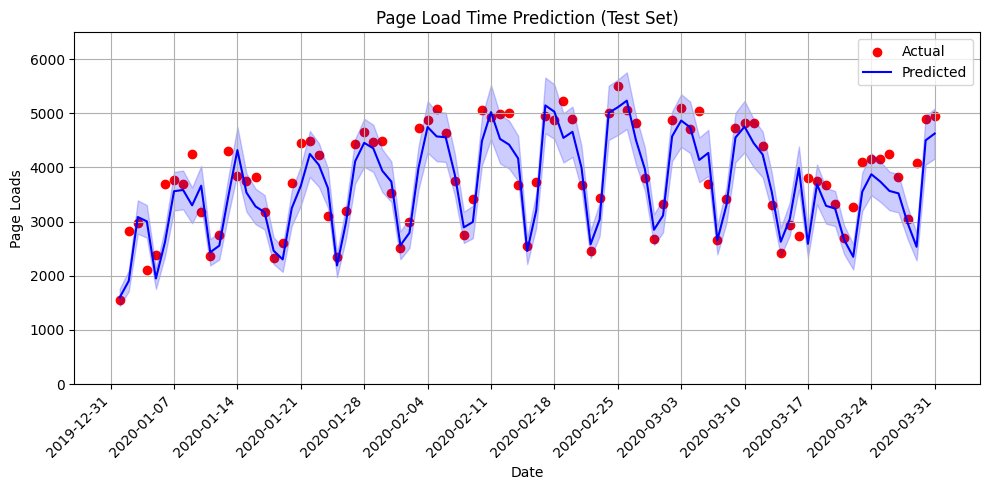

In [25]:
# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc['2020-01-01':'2020-03-31', 'Page.Loads']
date_time = '3 years'
# Ensure 1-dimensional arrays for metric calculation
y_test_actual = y_test_actual.to_numpy().flatten()
predicted_test = predicted_test.flatten()[:len(y_test_actual)]  # Ensure the prediction length matches the actual data length

# Calculate metrics
mse = mean_squared_error(y_test_actual, predicted_test)
rmse = np.sqrt(mse)  # Calculate RMSE
mae = mean_absolute_error(y_test_actual, predicted_test)
mape = np.mean(np.abs((y_test_actual - predicted_test) / y_test_actual)) * 100

# Store results
results_2017 = (start_date, end_date, rmse, mae, mape)

# Plot predictions
plot_predictions(data, y_test_actual, predicted_test, '2020-01-01', '2020-03-31', window_size, date_time)

## Step 8: Training and Evaluation for 2016 Data
# We train the model using data from 2016 and measure the training time.


In [26]:
# Prepare training data for 2016
start_date = '2016-01-01'
end_date = '2019-12-26'
scaler.fit(data.loc[start_date:end_date, ['Page.Loads']])
X_train, y_train = prepare_data(data, start_date, end_date, window_size, scaler)


c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [27]:
%%time
# Train the model for 2016 data
model = create_model(window_size)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1735
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0330
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0309 
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0296 
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0263 
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0226 
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0187 
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0115
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.0112
Epoch 13/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0099 
Epoch 14/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 
Epoch 15/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 
Epoch 16/50
46/4

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

c:\Users\Zebbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


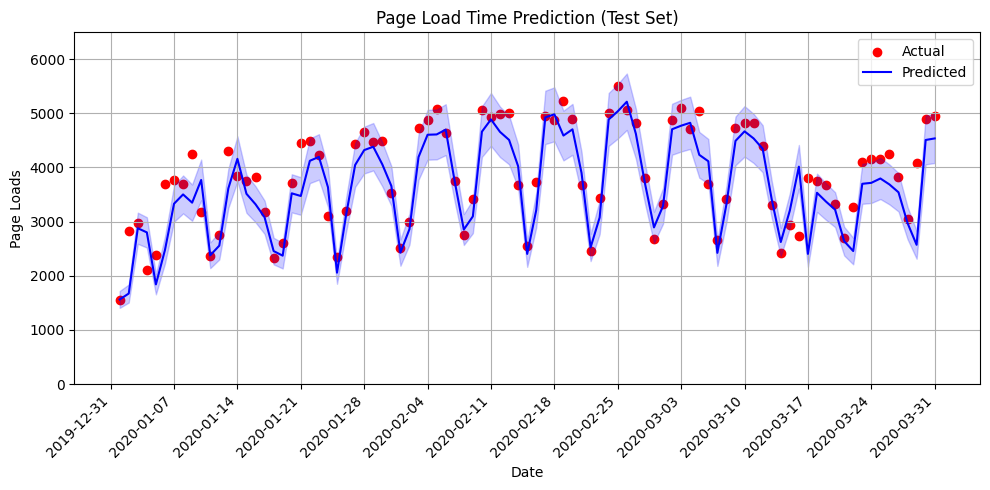

In [28]:
# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc['2020-01-01':'2020-03-31', 'Page.Loads']
date_time = '4 years'
# Ensure 1-dimensional arrays for metric calculation
y_test_actual = y_test_actual.to_numpy().flatten()
predicted_test = predicted_test.flatten()[:len(y_test_actual)]  # Ensure the prediction length matches the actual data length

# Calculate metrics
mse = mean_squared_error(y_test_actual, predicted_test)
rmse = np.sqrt(mse)  # Calculate RMSE
mae = mean_absolute_error(y_test_actual, predicted_test)
mape = np.mean(np.abs((y_test_actual - predicted_test) / y_test_actual)) * 100

# Store results
results_2016 = (start_date, end_date, rmse, mae, mape)

# Plot predictions
plot_predictions(data, y_test_actual, predicted_test, '2020-01-01', '2020-03-31', window_size, date_time)

## Step 9: Display Results
# Finally, we display the results for all training periods.

In [29]:
# Print results
for result in [results_2016, results_2017, results_2018, results_2019]:
    print(f"Training period: {result[0]} to {result[1]}")
    print(f"  RMSE: {result[2]}")
    print(f"  MAE: {result[3]}")
    print(f"  MAPE: {result[4]}")
    print("\n" + "-"*50 + "\n")

Training period: 2016-01-01 to 2019-12-26
  RMSE: 466.726582519793
  MAE: 344.1026141826923
  MAPE: 9.328509202992286

--------------------------------------------------

Training period: 2017-01-01 to 2019-12-26
  RMSE: 474.9022093003813
  MAE: 359.07443069625685
  MAPE: 9.668213881568342

--------------------------------------------------

Training period: 2018-01-01 to 2019-12-26
  RMSE: 488.94558407063414
  MAE: 385.636962890625
  MAPE: 11.139695751763453

--------------------------------------------------

Training period: 2019-01-01 to 2019-12-26
  RMSE: 506.32558146680486
  MAE: 415.464595585079
  MAPE: 12.217131896545661

--------------------------------------------------

